# Portfolio Management & Risk Modeling Using Low-Rank Matrix Completion
## Mohammad Alshurbaji
### Final Project of Advanced Machine Learning Course
#### Dr. Kai Lu
As my passion of working in the Finance Industry and dealing with stock market. I decided to do this project on Portfolio Management & Risk Modeling. 
This is project is about doing a Portfolio Management & Risk Modeling Using Low-Rank Matrix Completion using the Nuclear Norm Minimization

In [2]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/c5/98/6fd94db428a9670d638d4469cedfea51671de0126b8f50de1b06e2245c97/yfinance-0.2.50-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/04/13/d9839089b900fa7b479cce495d62110cddc4bd5630a04d8469916c0e79c5/frozendict-2.4.6-py311-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 10.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for html5lib>=1.1 from h

In [7]:
pip install cvxpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/7b/c3/58d34792c9f5085c6c0b10821780308276814e73bda5d1741f6946e443ee/cvxpy-1.6.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/55/72/8746c4bc488a31641091ccc50e71f92e0a4211e2ef882e00904940531962/osqp-0.6.7.post3-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for clarabel>=0.5.0 from https://files.pythonhosted.org/packages/8c/12/e92ba69884f84e0f16a9fb5093522924502995348f0269cc42ed062f2edc/clarabel-0.9.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scs>=3.2.4.post1 from https://files.pythonhosted.org/packages/ce/c8/d3e75a6bf7e0d8dce0fe591cea8d1266d7897601c29

In [19]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
from numpy.linalg import svd

#Defining the most interesting TECH Stocks (In my perspective)
tickers = ['AMZN', 'TSLA', 'NFLX', 'NVDA', 'MSFT', 'AAPL', 'CRM']
dataset = yf.download(tickers, start = '2019-12-01', end = '2022-12-01', interval = '1d')['Adj Close']
dataset.to_csv('LeadingTech_stock_prices.csv')
print(dataset.head())
print(dataset.shape)

[*********************100%***********************]  7 of 7 completed

Ticker           AAPL       AMZN         CRM        MSFT        NFLX  \
Date                                                                   
2019-12-02  64.024628  89.080002  160.288422  143.042404  309.989990   
2019-12-03  62.883060  88.498001  160.855896  142.812836  306.160004   
2019-12-04  63.438095  88.034500  155.738617  143.329361  304.320007   
2019-12-05  64.368797  87.024002  157.520706  143.405884  302.859985   
2019-12-06  65.612129  87.580002  157.311630  145.146667  307.350006   

Ticker          NVDA       TSLA  
Date                             
2019-12-02  5.209410  22.324667  
2019-12-03  5.169827  22.413334  
2019-12-04  5.213643  22.202000  
2019-12-05  5.196714  22.024668  
2019-12-06  5.282106  22.392668  
(756, 7)


# Data Preprocessing
In order to work with any data, the most important step is to process your data and normalize it, clean it if needed.

Total NaN values: 0
Total NaN values: 556


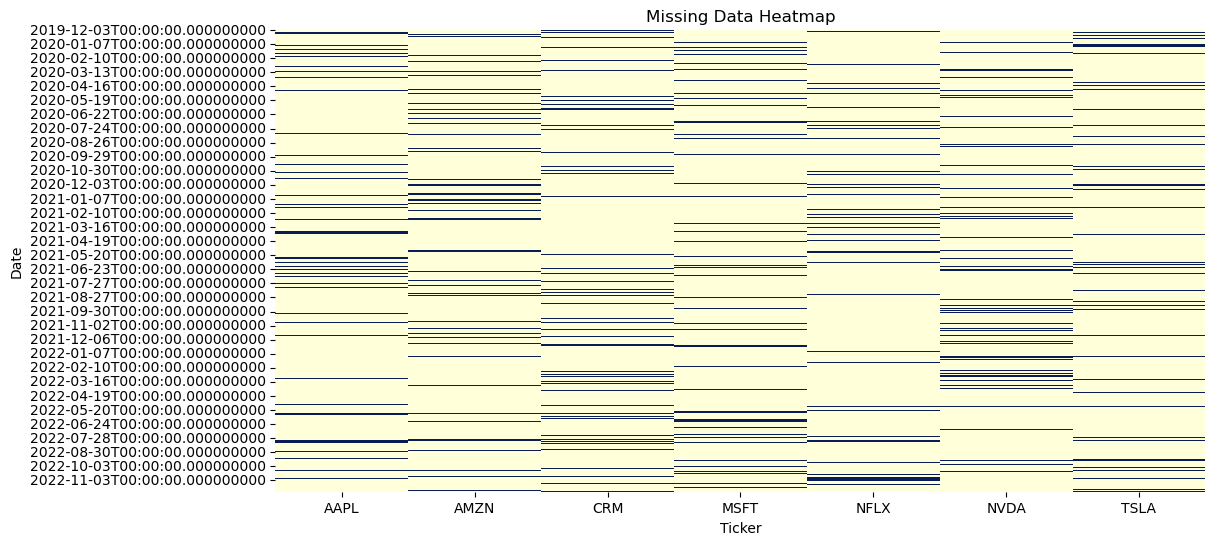

In [29]:
#Calculate the stock percentage change: formula: (Pt - P(t-1))/P(t-1)
returns = dataset.pct_change().dropna()
total_nan = returns.isna().sum().sum()
print(f"Total NaN values: {total_nan}")

#Introducing missing data (Simulating)
mask = np.random.rand(*returns.shape) < 0.1 #10% of the data will be missing by this
returns_missing = returns.mask(mask)
#To check how many values are missing
total_nan = returns_missing.isna().sum().sum()
print(f"Total NaN values: {total_nan}")

#Visualizing the data after simulation
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize Missing Data Pattern
plt.figure(figsize=(12, 6))
sns.heatmap(returns_missing.isna(), cmap='YlGnBu', cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

#Data Normalization
returns_normalized = (returns_missing-returns_missing.mean())/returns_missing.std()


# Matrix Completion using SVD
SVD is engine of Linear Algebra and in almost all the ML projects we need to implement it. 

In [4]:
#Fill missing values at the beginning
returns_filled = returns_missing.fillna(returns_missing.mean())

#SVD Implementation
U, Sigma, Vt = svd(returns_filled, full_matrices = False)
print(U.shape, Sigma.shape,Vt.shape)

k = 5 #keeping 5 singular values
Sigma_reduced = np.diag(Sigma[:k])
U_reduced = U[:,:k]
Vt_reduced = Vt[:k,:]
print(U_reduced.shape, Sigma_reduced.shape,Vt_reduced.shape)

# Reconstruct the Matrix
returns_completed = np.dot(U_reduced, np.dot(Sigma_reduced, Vt_reduced))

# Convert to DataFrame for better visualization
returns_completed_df = pd.DataFrame(returns_completed)
print(returns_completed_df.shape)

(755, 7) (7,) (7, 7)
(755, 5) (5, 5) (5, 7)
(755, 7)


# Method 2: CVXPY Library for Nuclear Norm and Data Completion

In [5]:
X = cp.Variable(returns_filled.shape)
objective = cp.Minimize(cp.norm(X,'nuc'))
constraints = [cp.multiply(~np.isnan(returns_missing),X) == np.nan_to_num(returns_missing)] #Obseved entries should be matched to the Original Data

#CVXPY Problem
problem = cp.Problem(objective, constraints)
problem.solve()

returns_completed2 = X.value
returns_completed_df2 = pd.DataFrame(returns_completed2)
print("Completed Matrix Shape:", returns_completed_df.shape)

Completed Matrix Shape: (755, 7)


# Covariance Matrix
## The Covariance matrix have been calculated for the two methods:
### - Cov from SVD Method
### - Cov from CVXPY Library that's using the Nuclier Norm Minimization Objective

In [6]:
#SVD Cov matrix
cov_matrix = np.cov(returns_completed_df.T)
print(cov_matrix.shape)
print(cov_matrix[:5,:5])
#CVXPY Cov matrix
cov_matrix2 = np.cov(returns_completed_df2.T)
print(cov_matrix2.shape)
print(cov_matrix2[:5,:5])

(7, 7)
[[0.00038209 0.00040092 0.00031845 0.00035143 0.00029174]
 [0.00040092 0.0004822  0.00034767 0.00036532 0.00042126]
 [0.00031845 0.00034767 0.00069457 0.00036365 0.0003714 ]
 [0.00035143 0.00036532 0.00036365 0.00033781 0.00028645]
 [0.00029174 0.00042126 0.0003714  0.00028645 0.00097758]]
(7, 7)
[[0.00050646 0.00035636 0.00038409 0.00039035 0.00034367]
 [0.00035636 0.00058202 0.0004129  0.00035885 0.00049102]
 [0.00038409 0.0004129  0.00072937 0.00041263 0.0004536 ]
 [0.00039035 0.00035885 0.00041263 0.0004561  0.00034694]
 [0.00034367 0.00049102 0.0004536  0.00034694 0.00100217]]


# Portfolio Optimization

In [17]:
#Portfolio Optimization (Mean-Variance Optimization)
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))
def portfolio_variance2(weights, cov_matrix2):
    return np.dot(weights.T, np.dot(cov_matrix2, weights))

# Constraints: Weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: No short-selling allowed
bounds = [(0, 1) for _ in range(cov_matrix.shape[0])]

# Initial Weights
initial_weights = np.ones(cov_matrix.shape[0]) / cov_matrix.shape[0]

# Optimize Portfolio
# Please note that the method SLSQP stands for Sequential Least Squares Programming which is constrained optimization method that handles equality nad inequality constraints
result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP',
                  bounds=bounds, constraints=constraints)
result2 = minimize(portfolio_variance2, initial_weights, args=(cov_matrix,), method='SLSQP',
                  bounds=bounds, constraints=constraints)
optimal_weights = result.x
optimal_weights2 = result2.x

# Evaluation
## The Evaluation metrics that have been used in this projects are:
### - Mean Squared Error
### - Mean Absolute Error
### - Root Mean Squared Error
### - Frobenius Norm
### - Visualizing the singular valuse for the original dataset singular values and the completed ones

The observed MSE error from SVD is :  0.00011607661724753064
The observed MSE error from CVXPY is :  5.213824835368289e-05
The observed MAE error from SVD is :  0.005134938673964933
The observed MAE error from CVXPY is :  0.0014589626975223572
The observed MAE error from SVD is :  0.07165848640576308
The observed MAE error from CVXPY is :  0.03819637021396611
Frobenius Norm of Error Matrix from SVD: 0.783240
Frobenius Norm of Error Matrix from CVXPY: 0.524929


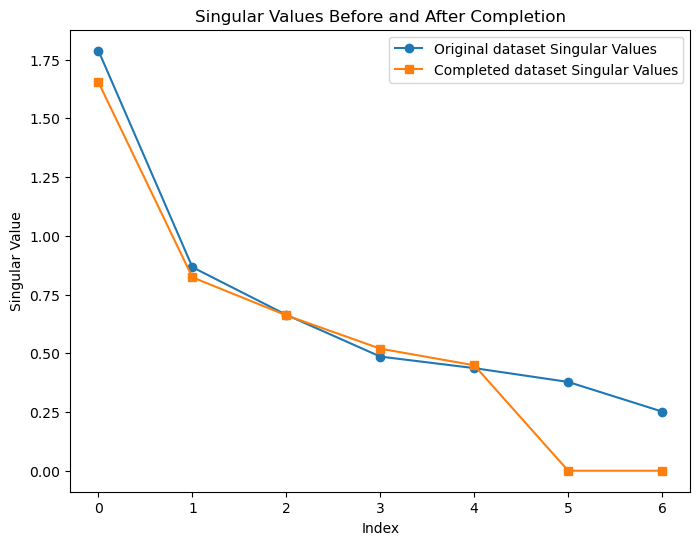

In [33]:
#Mean Squared Error metric
mse_error_svd = mean_squared_error(returns.values, returns_completed_df.values)
mse_error_cvxpy = mean_squared_error(returns.values, returns_completed_df2.values)
print("The observed MSE error from SVD is : ", mse_error_svd)
print("The observed MSE error from CVXPY is : ", mse_error_cvxpy)
#Mean Absolute Error metric
mae_error_svd = mean_absolute_error(returns.values, returns_completed_df.values)
mae_error_cvxpy = mean_absolute_error(returns.values, returns_completed_df2.values)
print("The observed MAE error from SVD is : ", mae_error_svd)
print("The observed MAE error from CVXPY is : ", mae_error_cvxpy)
#Root Mean Squared Error
rmse_error_svd = np.sqrt(mae_error_svd)
rmse_error_cvxpy = np.sqrt(mae_error_cvxpy)
print("The observed MAE error from SVD is : ", rmse_error_svd)
print("The observed MAE error from CVXPY is : ", rmse_error_cvxpy)

# Calculate Frobenius Norm for SVD
error_matrix = returns.values - returns_completed_df.values
frobenius_norm = np.linalg.norm(error_matrix, 'fro')
print(f"Frobenius Norm of Error Matrix from SVD: {frobenius_norm:.6f}")

# Calculate Frobenius Norm for cvxpy
error_matrix2 = returns.values - returns_completed_df2.values
frobenius_norm2 = np.linalg.norm(error_matrix2, 'fro')
print(f"Frobenius Norm of Error Matrix from CVXPY: {frobenius_norm2:.6f}")

# Visualizing the singular valuse for the original dataset singular values and the completed ones
from numpy.linalg import svd

_, sigma_original, _ = svd(returns)
_, sigma_completed, _ = svd(returns_completed_df)

# Plot Singular Values
plt.figure(figsize=(8, 6))
plt.plot(sigma_original, label="Original dataset Singular Values", marker="o")
plt.plot(sigma_completed, label="Completed dataset Singular Values", marker="s")
plt.title("Singular Values Before and After Completion")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.legend()
plt.show()

# Visualization
## Here is the visualization of the Portfolio performance after obtimization.

Optimal Portfolio Weights:
  Stock  Optimal Weight
0  AAPL        0.142857
1  AMZN        0.142857
2   CRM        0.142857
3  MSFT        0.142857
4  NFLX        0.142857
5  NVDA        0.142857
6  TSLA        0.142857
Optimal Portfolio Weights from CVXPY:
  Stock  Optimal Weight
0  AAPL        0.142857
1  AMZN        0.142857
2   CRM        0.142857
3  MSFT        0.142857
4  NFLX        0.142857
5  NVDA        0.142857
6  TSLA        0.142857


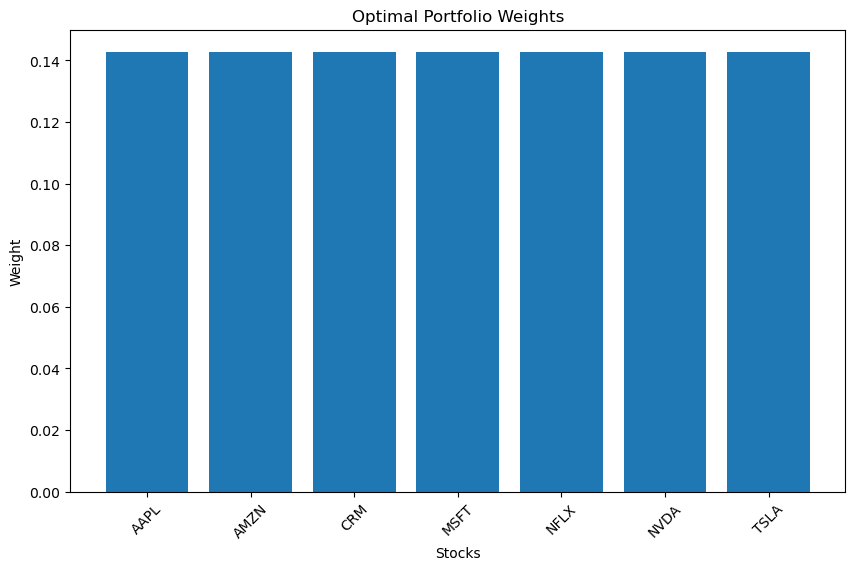

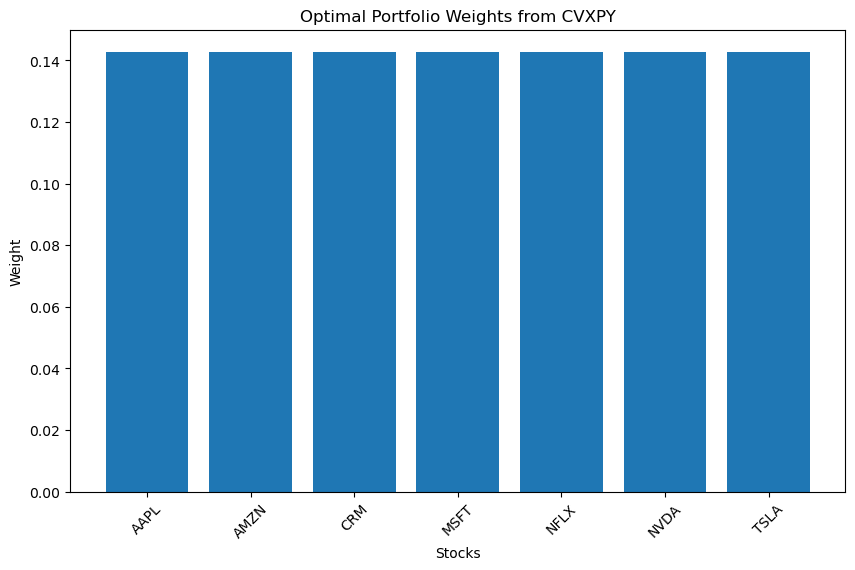

Reconstruction Error (MSE): 0.000116


In [18]:
# Display Results
optimal_portfolio = pd.DataFrame({'Stock': returns.columns, 'Optimal Weight': optimal_weights})
optimal_portfolio_sorted = optimal_portfolio.sort_values(by='Optimal Weight', ascending=False)

optimal_portfolio2 = pd.DataFrame({'Stock': returns.columns, 'Optimal Weight': optimal_weights2})
optimal_portfolio_sorted2 = optimal_portfolio2.sort_values(by='Optimal Weight', ascending=False)

# Display Portfolio Weights
print("Optimal Portfolio Weights:")
print(optimal_portfolio_sorted)

# Display Portfolio Weights
print("Optimal Portfolio Weights from CVXPY:")
print(optimal_portfolio_sorted2)

# Plot Optimal Portfolio
plt.figure(figsize=(10, 6))
plt.bar(optimal_portfolio_sorted['Stock'], optimal_portfolio_sorted['Optimal Weight'])
plt.title('Optimal Portfolio Weights')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.show()

# Plot Optimal Portfolio
plt.figure(figsize=(10, 6))
plt.bar(optimal_portfolio_sorted2['Stock'], optimal_portfolio_sorted2['Optimal Weight'])
plt.title('Optimal Portfolio Weights from CVXPY')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.show()